<a href="https://colab.research.google.com/github/vokashlob/OTUS/blob/main/OTUS_torch_practice_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Создать и обучить регрессионную модель, которая аппроксимирует значение 
функции sin(x + 2*y)*exp(-(2*x + y)^2) на диапазоне значений [-10;10] по х и у.
2. В качестве обучающей выборки необходимо сгенерировать 20000 точек случайным образом.
3. Разделить получившийся датасет на train / test / val в отношениях 70% / 15% / 15%, соответственно.

Результаты: a) Посчитать метрику Mean Square Error(MSE) на test. b) Нарисовать график, в котором сравнивается истинная функция и ее аппроксимированный вариант (предсказываемый моделью).

# Импорт


In [20]:
import numpy as np
import math
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
%matplotlib inline

# Создаем данные

In [21]:
data = 20*np.random.rand(20000,3)-10
x = data[:,0]
y = data[:,1]
data[:,2] = np.sin(x + 2*y)*np.exp(-(2*x + y)**2)
data.shape

(20000, 3)

Разброс значений функции


In [22]:
print(data[:,2].min(), data[:,2].max())

-0.9994072676251595 0.9954956850926404


# Смотрим на данные в 3D и в 2D

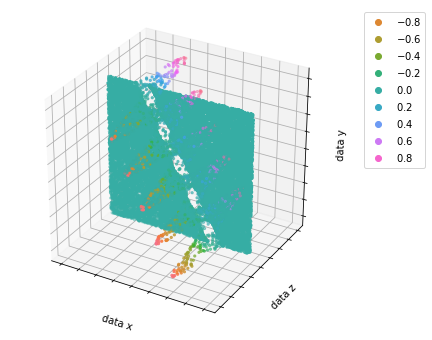

In [23]:
z = data[:,2]
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x, z, y, s=5, c=z, cmap=cmap)
ax.set_xlabel('data x')
ax.set_ylabel('data z')
ax.set_zlabel('data y')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show();

<Figure size 432x288 with 0 Axes>

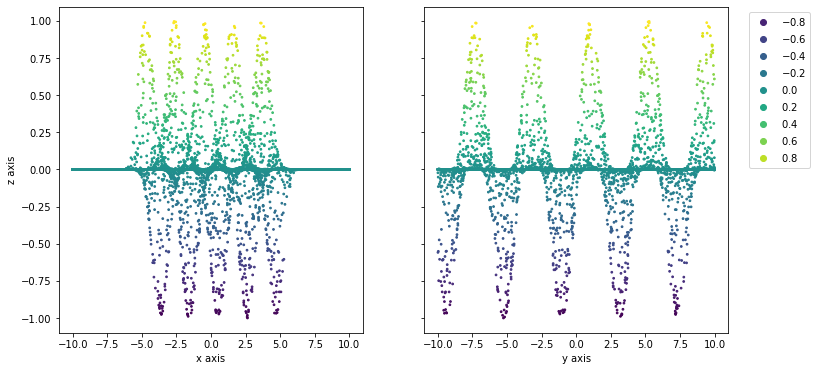

In [24]:
plt.clf();
fig = plt.figure(figsize=(12,6));
ax=fig.add_subplot(121);
plt.scatter(x, z, c=z, s=3);
plt.xlabel('x axis');
plt.ylabel('z axis');
ax=fig.add_subplot(122);
sc = ax.scatter(y, z, c=z, s=3);
plt.xlabel('y axis');
ax.set_yticklabels([]);
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show();

# train_test_split


In [25]:
X_train, X_test, y_train, y_test = train_test_split(data[:, :2], z, test_size=.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5, random_state=42)
print('Размеры:')
print(f'Тренировочные фичи: {X_train.shape}, тeстовые фичи: {X_test.shape}, валидационные фичи: {X_val.shape}')
print(f'Тренировочные таргеты: {y_train.shape}, тестовые таргеты: {y_test.shape}, валидационные таргеты: {y_val.shape}')

Размеры:
Тренировочные фичи: (14000, 2), тeстовые фичи: (3000, 2), валидационные фичи: (3000, 2)
Тренировочные таргеты: (14000,), тестовые таргеты: (3000,), валидационные таргеты: (3000,)


# Низкоуровневый вариант (вне задания, для себя)

In [ ]:
X_tensor = torch.from_numpy(X_train).float()
y_tensor = torch.from_numpy(y_train).float()
y_tensor.shape

torch.Size([14000])

In [ ]:
def lin_reg_model(X, w, b):
    return torch.matmul(X, w.T) + b

In [ ]:
def mse(true, predicted):
    return ((true - predicted) ** 2).sum() / true.numel()

In [ ]:
# по мотивами Kaiming initialization
weight = torch.randn(y_tensor.shape[0], X_tensor.shape[1]) / math.sqrt(2 / y_tensor.shape[0])
bias = torch.zeros(y_tensor.shape[0])
# начинаем записывать историю вычислений
weight.requires_grad_(True)
bias.requires_grad_(True);

In [ ]:
learning_rate = 1
epochs = 10000

for epoch in range(epochs):
    # forward pass — вычисляем функцию потерь
    predictions = lin_reg_model(X_tensor.to('cuda'), weight.to('cuda'), bias.to('cuda'))
    loss = mse(predictions, y_tensor.to('cuda'))
    # backward paass — вычисляем градиент
    loss.backward()
    # вычитаем производные из параметров
    # записывать историю вычислений уже не нужно (no_grad)
    with torch.no_grad():
        weight -= weight.grad * learning_rate
        bias -= bias.grad * learning_rate
        # обнуляем производные
        weight.grad.zero_()
        bias.grad.zero_()
    # выводим значение фукнции потерь каждые 2000 повторов
    if (epoch + 1) % 100 == 0:
      print('epoch {}, loss {}'.format(epoch + 1, loss.item()))

epoch 100, loss 14.136964797973633
epoch 200, loss 5.508139133453369
epoch 300, loss 2.154475450515747
epoch 400, loss 0.8506031632423401
epoch 500, loss 0.3433662950992584
epoch 600, loss 0.1457935869693756
epoch 700, loss 0.06861793994903564
epoch 800, loss 0.0382661297917366
epoch 900, loss 0.026133352890610695
epoch 1000, loss 0.021096210926771164
epoch 1100, loss 0.01882835477590561
epoch 1200, loss 0.017646657302975655
epoch 1300, loss 0.016896063461899757
epoch 1400, loss 0.016321444883942604
epoch 1500, loss 0.015823284164071083
epoch 1600, loss 0.01536262221634388
epoch 1700, loss 0.014924071729183197
epoch 1800, loss 0.014501433819532394
epoch 1900, loss 0.01409208495169878
epoch 2000, loss 0.013694808818399906
epoch 2100, loss 0.013308932073414326
epoch 2200, loss 0.012934005819261074
epoch 2300, loss 0.012569671496748924
epoch 2400, loss 0.012215612456202507
epoch 2500, loss 0.011871530674397945
epoch 2600, loss 0.011537143029272556
epoch 2700, loss 0.011212176643311977
epo

# Вариант на фреймворке

### Определяем собственный Dataset


In [26]:
class myData(Dataset):
    def __init__(self, X, Y):
      self.X = X
      self.Y = Y
      if len(self.X) != len(self.Y):
        raise Exception("Размерность X не совпадает с размерностью Y")
        
    def __len__(self):
      return len(self.X)
      
    def __getitem__(self, index):
      # note that this isn't randomly selecting. It's a simple get a single item that represents an x and y
      _x = self.X[index]
      _y = self.Y[index]
      return _x, _y

In [27]:
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

### Модель

In [196]:
class Regression(nn.Module):
    def __init__(self, inputSize, outputSize):
        super(Regression, self).__init__()
        self.linear1 = nn.Linear(inputSize, 4)
        self.linear2 = nn.Linear(4, 2)
        self.linear3 = nn.Linear(2, outputSize)

    def forward(self, X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = F.relu(self.linear3(X))
        return X

### параметры

In [206]:
model = Regression(2, 1)
criterion = nn.MSELoss()

learning_rate = 0.0001
epochs = 50
batch_size = 256

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [207]:
train_loader = DataLoader(myData(X_train_tensor, y_train_tensor.view(-1, 1)), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(myData(X_test_tensor, y_test_tensor.view(-1, 1)), batch_size=batch_size, shuffle=False)

### тренировка

In [208]:
model.train()
for epoch in range(epochs):
  for data in train_loader:
    X, y = data
    optimizer.zero_grad()
    predictions = model(X)
    loss = criterion(predictions, y)
    # get gradients
    loss.backward()
    # update parameters
    optimizer.step()

  print('epoch {}, loss {}'.format(epoch, loss.item()))

epoch 0, loss 0.4851168394088745
epoch 1, loss 0.46392858028411865
epoch 2, loss 0.4701613187789917
epoch 3, loss 0.44778433442115784
epoch 4, loss 0.41773471236228943
epoch 5, loss 0.4513009786605835
epoch 6, loss 0.38698986172676086
epoch 7, loss 0.39760321378707886
epoch 8, loss 0.39458930492401123
epoch 9, loss 0.34818726778030396
epoch 10, loss 0.3544982969760895
epoch 11, loss 0.3397810757160187
epoch 12, loss 0.32769888639450073
epoch 13, loss 0.33688056468963623
epoch 14, loss 0.3392927348613739
epoch 15, loss 0.2995774447917938
epoch 16, loss 0.2959655225276947
epoch 17, loss 0.2886831760406494
epoch 18, loss 0.2661929428577423
epoch 19, loss 0.2914074957370758
epoch 20, loss 0.2712729871273041
epoch 21, loss 0.24717189371585846
epoch 22, loss 0.2389417588710785
epoch 23, loss 0.2562406361103058
epoch 24, loss 0.20626460015773773
epoch 25, loss 0.21390067040920258
epoch 26, loss 0.21782852709293365
epoch 27, loss 0.22711843252182007
epoch 28, loss 0.21266217529773712
epoch 29,

### тестирование

In [209]:
model.eval()
test_preds = []
test_labels = []
test_features = []
for X, y in test_loader:
    test_features += list(X.numpy())
    test_labels += list(y)
    test_preds += list(model.forward(X).detach().numpy())

assert len(test_preds) == len(test_labels)

print(f'MSE на тестовой выборке: {mean_squared_error(test_labels, test_preds)}')

MSE на тестовой выборке: 0.08813679963350296


### Рисуем график

In [210]:
test_features_x1 = [x[0] for x in test_features]
test_features_x2 = [x[1] for x in test_features]

<Figure size 432x288 with 0 Axes>

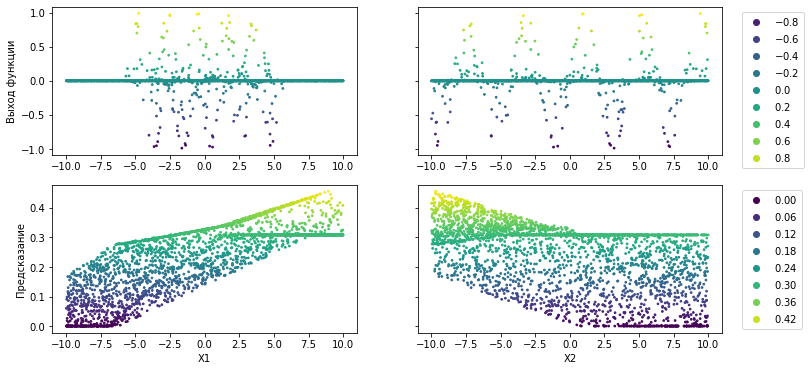

In [211]:
plt.clf();
fig = plt.figure(figsize=(12,6));
ax=fig.add_subplot(221);
plt.scatter(test_features_x1, test_labels, c=test_labels, s=3);
plt.ylabel('Выход функции');
ax=fig.add_subplot(222);
sc = ax.scatter(test_features_x2, test_labels, c=test_labels, s=3);
ax.set_yticklabels([]);
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2);
ax=fig.add_subplot(223);
plt.scatter(test_features_x1, test_preds, c=test_preds, s=3);
plt.xlabel('X1');
plt.ylabel('Предсказание');
ax=fig.add_subplot(224);
sc = ax.scatter(test_features_x2, test_preds, c=test_preds, s=3);
plt.xlabel('X2');
ax.set_yticklabels([]);
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2);
plt.show();

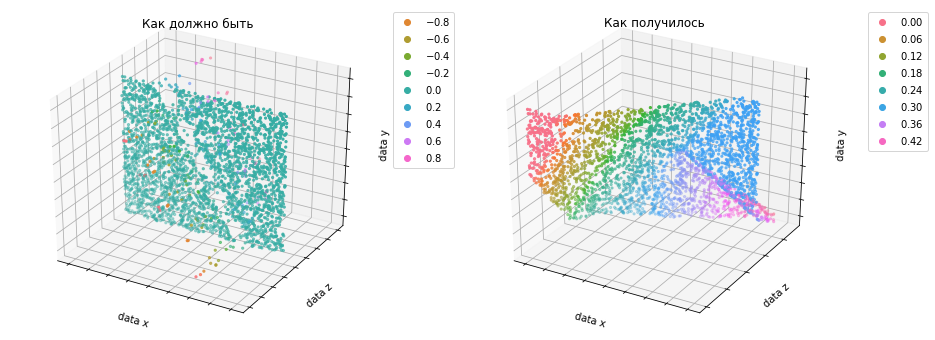

In [212]:
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121, projection='3d')
sc = ax.scatter(test_features_x1, test_labels, test_features_x2, s=5, c=test_labels, cmap=cmap)
ax.set_xlabel('data x')
ax.set_ylabel('data z')
ax.set_zlabel('data y')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1, 1), loc=2)
plt.title('Как должно быть')
ax = fig.add_subplot(122, projection='3d')
sc = ax.scatter(test_features_x1, test_preds, test_features_x2, s=5, c=test_preds, cmap=cmap)
ax.set_xlabel('data x')
ax.set_ylabel('data z')
ax.set_zlabel('data y')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.title('Как получилось')
plt.show();